In [2]:
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=16)

torch.manual_seed(1234)
dataset = SMRTDataset('./SMRT')
train_len = int(dataset.__len__() * 0.9)
test_len = dataset.__len__() - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])
train_len_2 = int(train_len * 0.9)
dev_len = train_len - train_len_2
train_dataset, dev_data_set = random_split(train_dataset, [train_len_2, dev_len])

In [ ]:
test_data_frame = pd.DataFrame(index=range(10000000),columns=['inchi', 'formula','real_rt'])
for i in range(len(test_dataset)):
    data = test_dataset[i]
    test_data_frame.loc[i] = {'inchi':data.inchi,'formula':data.formula,'real_rt':data.y.cpu().item()}

In [3]:
import os
from tqdm import tqdm
import multiprocessing
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from functools import partial
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=16)

torch.manual_seed(1234)

dataset = SMRTDataset('./SMRT')

train_len = int(dataset.__len__() * 0.9)
test_len = dataset.__len__() - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

train_len_2 = int(train_len * 0.9)
dev_len = train_len - train_len_2
train_dataset, dev_data_set = random_split(train_dataset, [train_len_2, dev_len])

test_data_frame = pd.DataFrame(columns=['inchi', 'formula','real_rt'])
for i in range(len(test_dataset)):
    data = test_dataset[i]
    test_data_frame.loc[i] = {'inchi':data.inchi,'formula':data.formula,'real_rt':data.y.cpu().item()}
path = 'results_of_search_smrt_all'
# frame = pd.DataFrame(columns=['inchi_true','rt_true','inchi','rt_pred'])
frame_list = multiprocessing.Manager().list([None for _ in range(len(test_data_frame))])
def transfer(index_file,frame_list_to_write):
    inchi_true = test_data_frame['inchi'][index_file]
    rt_true = test_data_frame['real_rt'][index_file]
    formula = test_data_frame['formula'][index_file]
    if os.path.exists(f'./{path}/{formula}_results.csv'):
        csv = pd.read_csv(f'./{path}/{formula}_results.csv')
        frame = pd.DataFrame(index=range(10000),columns=['inchi_true','rt_true','inchi','rt_pred'])
        for j in range(len(csv)):
            frame.loc[j] = {
                            'inchi_true':inchi_true,
                            'rt_true':rt_true,
                            'inchi':csv['inchi'][j],
                            'rt_pred':csv['pred_rt'][j]
                            }
            
        frame_list_to_write[index_file] = frame
        # print(f'{index_file}success')



partial_work = partial(transfer, frame_list_to_write=frame_list)
x = list(range(len(test_data_frame)))

with Pool(processes = 50) as pool:
    result = list(tqdm(pool.imap(partial_work, x), total=len(test_data_frame)))


100%|██████████| 8004/8004 [14:50<00:00,  8.98it/s] 


In [4]:
frame = pd.concat(frame_list)
frame = frame.dropna()

In [ ]:


frame.to_csv('./results/all_predictions_of_search_by_all.csv')

In [2]:
import os
from tqdm import tqdm
import multiprocessing
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from functools import partial


frame = pd.read_csv('./results/all_predictions_of_search_by_all.csv')

In [3]:
frame['pos'] = frame['inchi']==frame['inchi_true']
frame['re'] = 100*abs(frame['rt_true']-frame['rt_pred'])/frame['rt_true']

In [4]:
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib

def ROC(df, threshold):
    # TPR=[]
    # FPR=[]
    TPR=[0]*len(threshold)
    FPR=[0]*len(threshold)

    # df['pos'] = df['inchi']==df['inchi_true']
    P = len(df[df.pos==True])
    N = len(df[df.pos==False])
    # print(P, N)
    for index, thresh in enumerate(tqdm(threshold)):
        df['pos_thresh'] = df['re']<thresh
        TP = len(df[(df['pos']==True)&(df['pos_thresh']==True)])
        FP = len(df[(df['pos']==False)&(df['pos_thresh']==True)])
        TPR[index] = TP/P
        FPR[index] = FP/N
        # TPR.append(TP/P)
        # FPR.append(FP/N)
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))])
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in tqdm(range(len(FPR)-1)):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

threshold=np.arange(0, 200, 0.1)
TPR, FPR, thresh = ROC(frame, threshold)
AUC = ROC_AUC(TPR, FPR)


100%|██████████| 2000/2000 [1:17:10<00:00,  2.32s/it]


Best threshold: 5.7


100%|██████████| 1999/1999 [00:00<00:00, 2215754.15it/s]


In [5]:
def get_search_space_reduction(df, threshold):
    df['filtered'] = df['re']>threshold
    inchi_list = df[df['pos']==True].inchi
    total, filtered=[0]*len(inchi_list),[0]*len(inchi_list)
    
    for index, inchi in enumerate(tqdm(inchi_list)):
        new_df = df[df['inchi_true']==inchi]
        total[index] = len(new_df)
        filtered[index] = len(new_df[new_df['filtered'] ==True])
        # total.append(len(new_df))
        # filtered.append(len(new_df[new_df['filtered'] ==True]))
    return total, filtered
total, filtered = get_search_space_reduction(frame,thresh)

100%|██████████| 7533/7533 [2:50:13<00:00,  1.36s/it]  


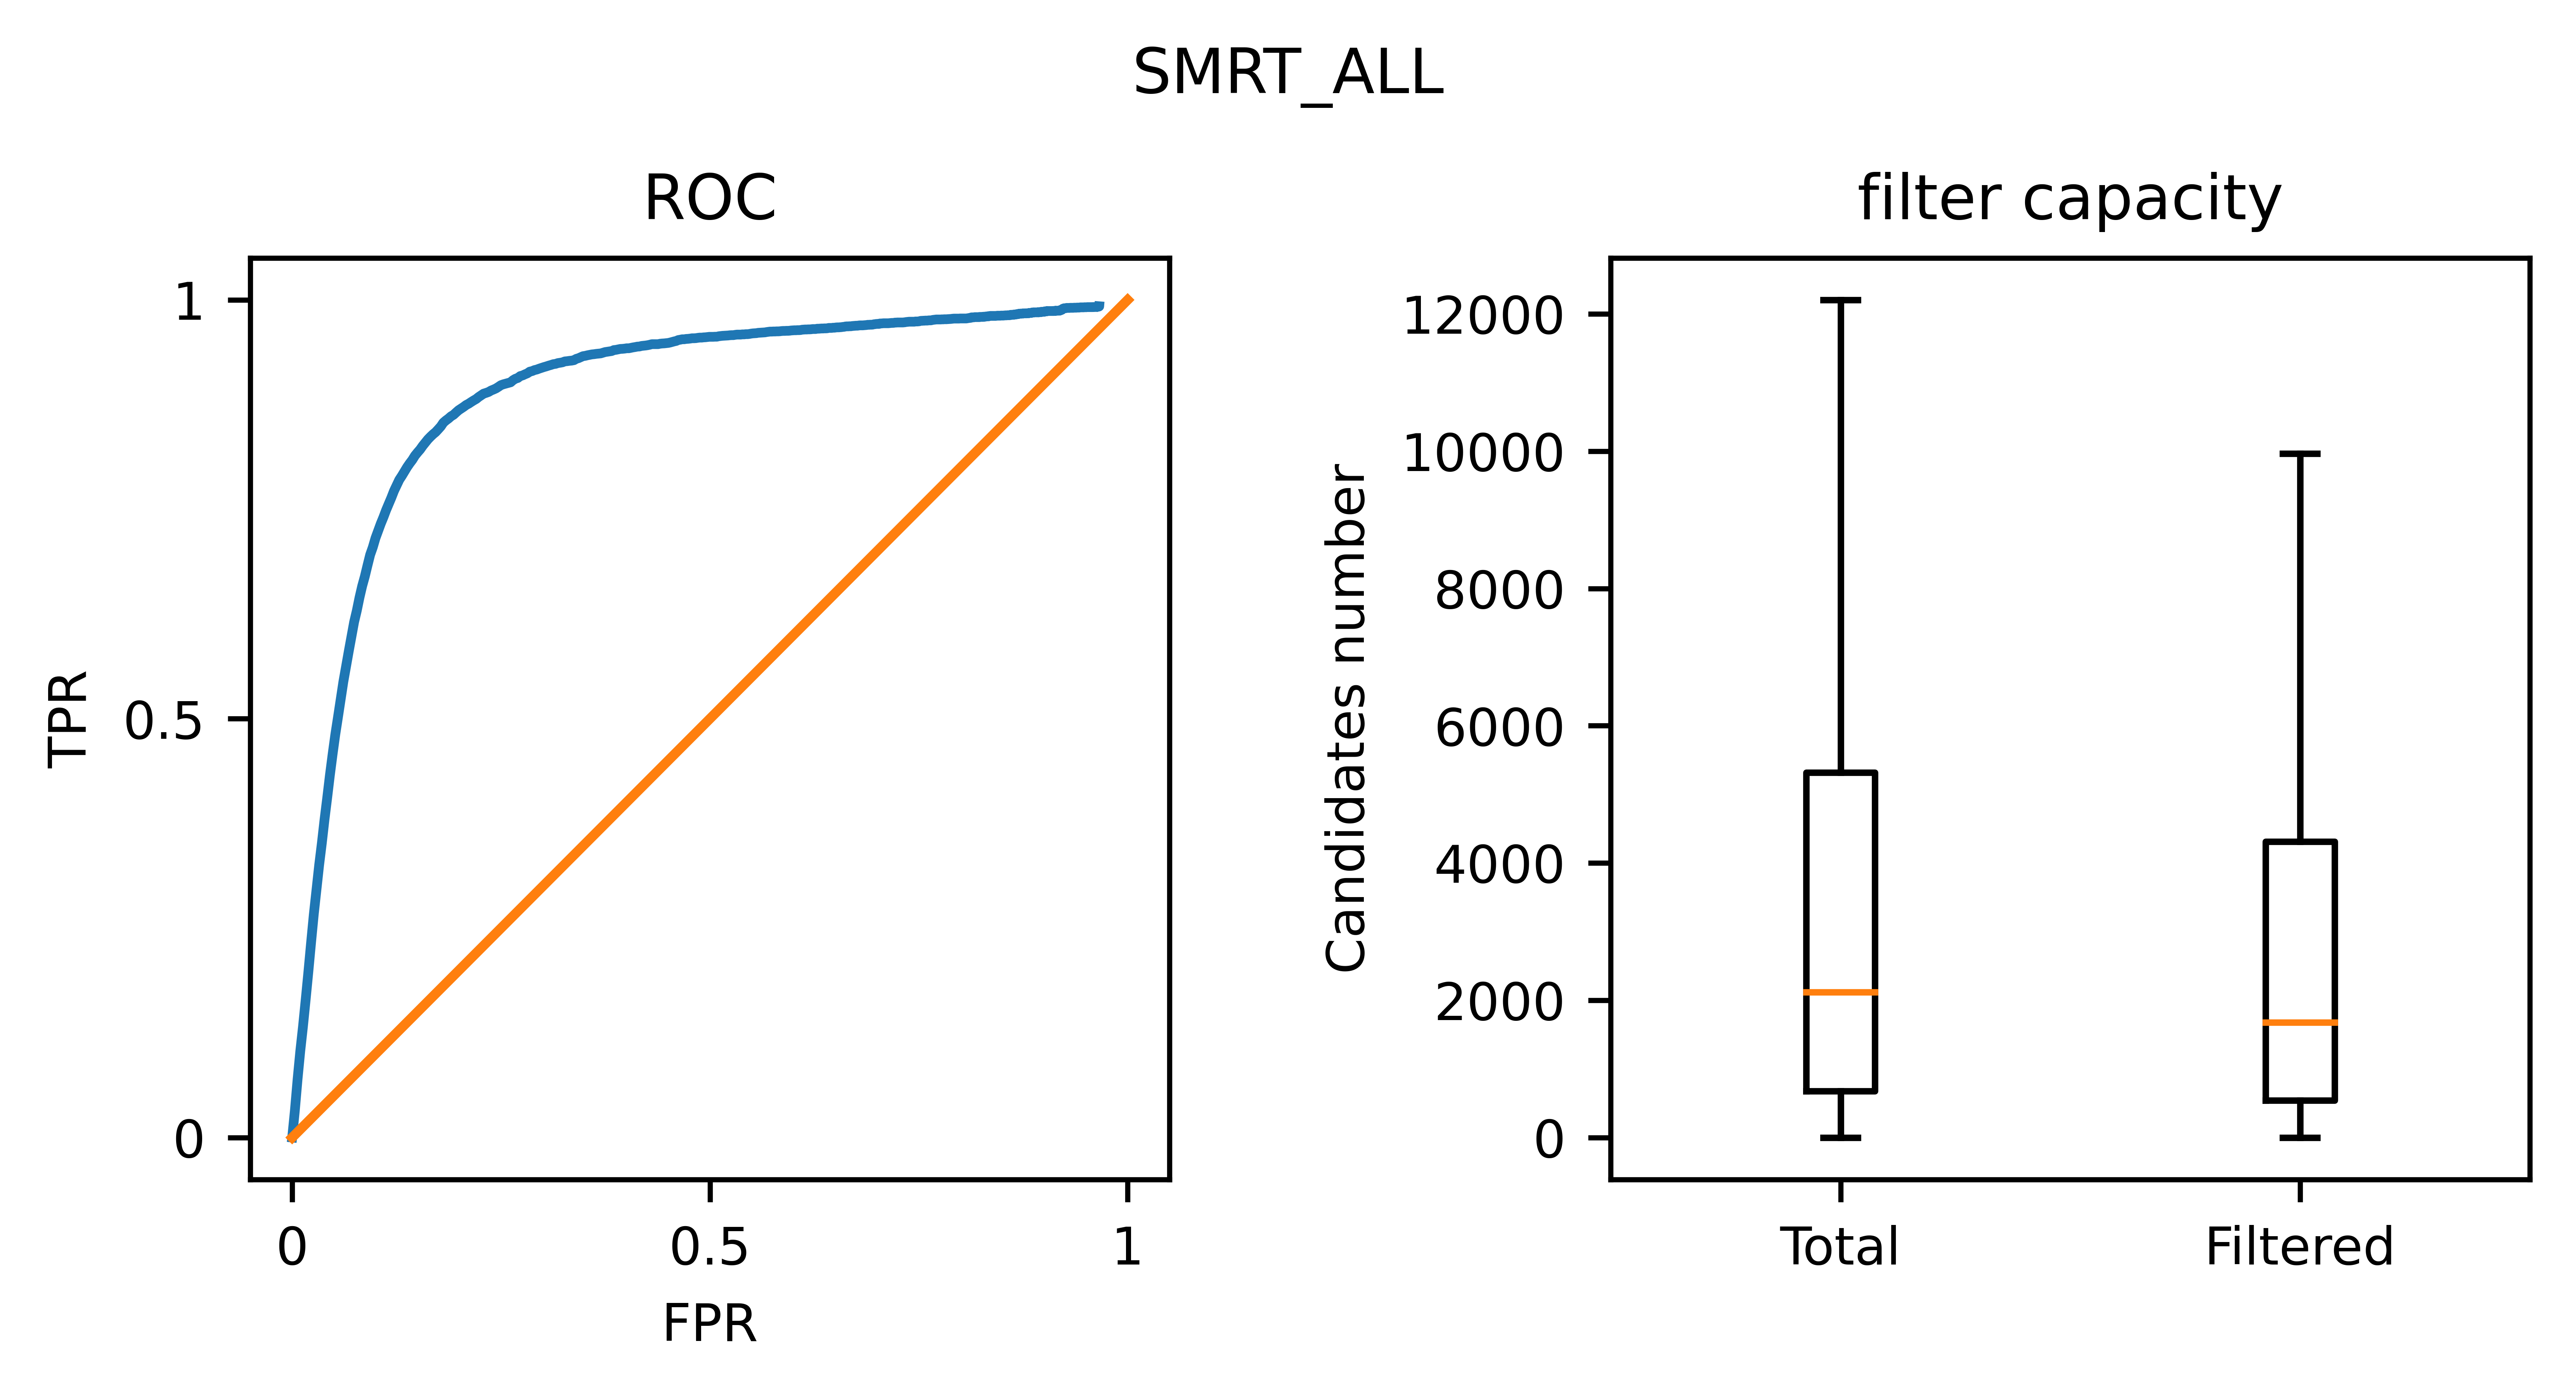

In [10]:
x=[0,1]
y=[0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(1,2, figsize=(6, 3.2), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 8})
# for ds in [ds_name]:
    #print(st.mean(RF[ds]))
axs[0].plot(FPR, TPR)
axs[0].plot(x,y)
axs[0].set_yticks([0,0.5, 1])
axs[0].set_xticks([0,0.5, 1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_yticklabels(['0', '0.5', '1'])
axs[0].set_xticklabels(['0', '0.5', '1'])
axs[0].set_title('ROC')


axs[1].boxplot((total, filtered), showfliers=False)
axs[1].set_xticklabels(labels, fontsize=8)
axs[1].set_ylabel('Candidates number')
fig.tight_layout(pad=3.0)
axs[1].set_title('filter capacity')
fig.suptitle('SMRT_ALL')
plt.savefig(f'./figs/all_ROC_AUC={AUC:.2f}_threshold={thresh}.svg',)